<a href="https://colab.research.google.com/github/bratati30/Projects/blob/main/Military_Vehicle_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip /content/gdrive/MyDrive/normal-vs-military-vehicles.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm# Tensorflow Libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Specify the directory containing the images
directory = "/content/dataset/train"


# Create an ImageDataGenerator
datagen = ImageDataGenerator()

# Use flow_from_directory to get the number of samples
num_images = len(datagen.flow_from_directory(directory).filepaths)

print("Number of images:", num_images)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)


In [ ]:

def walk_through_dir(directory):
    """
    Recursively walk through a directory and print out its contents.
    """
    for dirpath, dirnames, filenames in os.walk(directory):
        print(f"Directory: {dirpath}")
        print("Subdirectories:", dirnames)
        print("Files:", filenames)

        # Convert the list of filenames to a list of total number of files
        total_files = len(filenames)
        print("Total number of files:", total_files)

        print()

# Example usage:
directory = "/content/dataset"
walk_through_dir(directory)



# Placing data into a Dataframe

In [ ]:
image_dir = Path(directory)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df


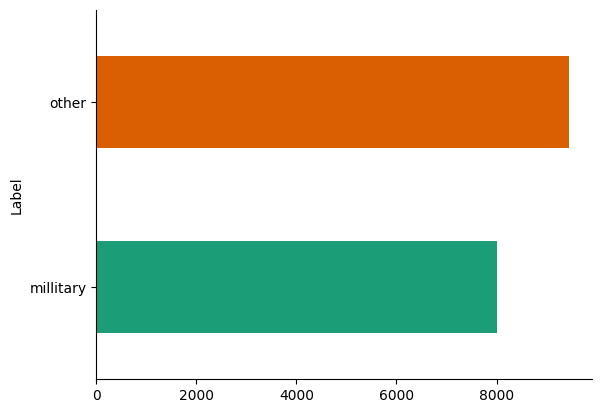

In [ ]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
image_df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Visualizing images from the dataset

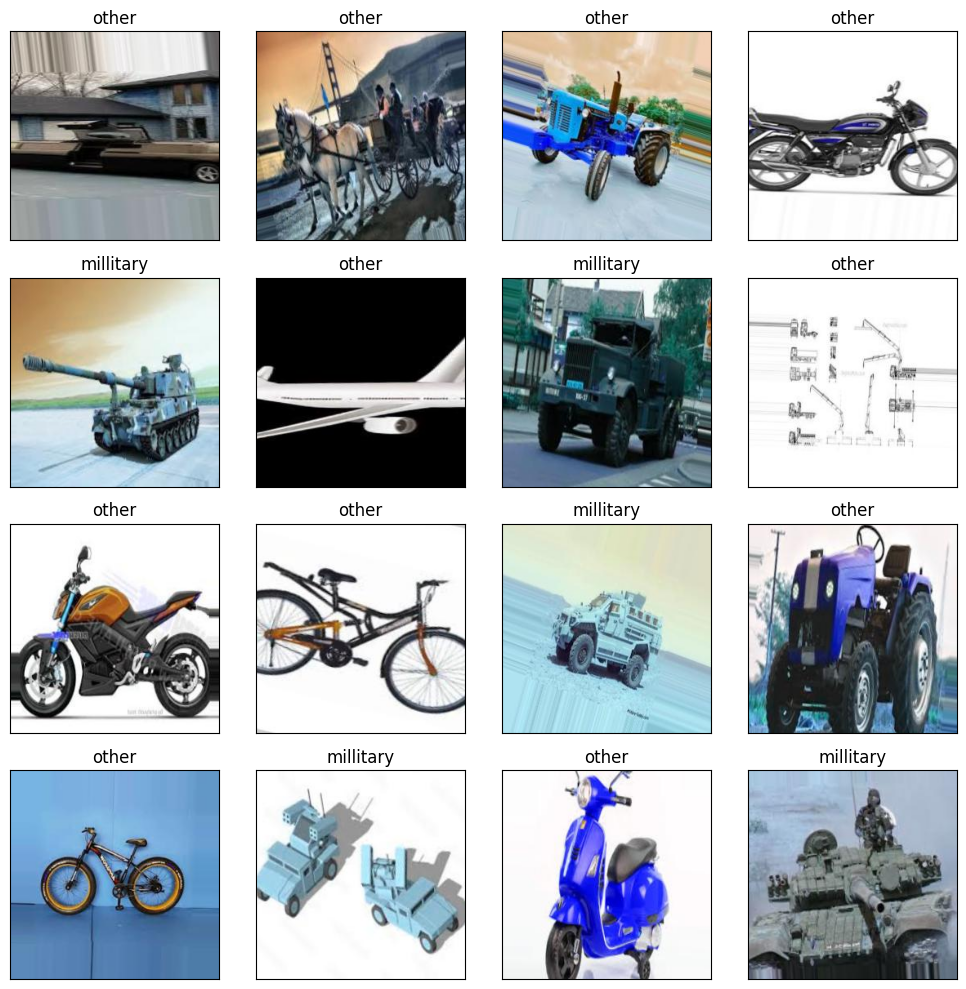

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# DATA PREPROCESSING

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# SPLIT DATA

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11170 validated image filenames belonging to 2 classes.
Found 2792 validated image filenames belonging to 2 classes.
Found 3491 validated image filenames belonging to 2 classes.


RESIZE LAYER

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# LOAD THE MODEL

In [ ]:
# Define your custom model
inputs = layers.Input(shape=(224, 224, 3))
x = preprocessing.Resizing(224, 224)(inputs)
x = preprocessing.Rescaling(1./255)(x)

x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(2, activation='sigmoid')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [ ]:
# Define the new checkpoint path
checkpoint_path = "my_model_checkpoint"

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='sigmoid')(x) #Original softmax

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
350/350 [==============================] - 32s 82ms/step - loss: 0.5627 - accuracy: 0.7111 - val_loss: 0.3880 - val_accuracy: 0.8542
Epoch 2/10
350/350 [==============================] - 34s 97ms/step - loss: 0.3686 - accuracy: 0.8473 - val_loss: 0.2892 - val_accuracy: 0.8900
Epoch 3/10
350/350 [==============================] - 28s 81ms/step - loss: 0.2986 - accuracy: 0.8831 - val_loss: 0.2450 - val_accuracy: 0.9047
Epoch 4/10
350/350 [==============================] - 28s 81ms/step - loss: 0.2601 - accuracy: 0.8970 - val_loss: 0.2206 - val_accuracy: 0.9137
Epoch 5/10
350/350 [==============================] - 28s 79ms/step - loss: 0.2339 - accuracy: 0.9094 - val_loss: 0.2054 - val_accuracy: 0.9205
Epoch 6/10
350/350 [==============================] - 28s 80ms/step - loss: 0.2166 - accuracy: 0.9149 - val_loss: 0.1952 - val_accuracy: 0.9241
Epoch 7/10
350/350 [==============================] - 28s 79ms/step - loss: 0.2069 - accuracy: 0.9207 - val_loss: 0.1860 - val_accuracy:

# VISUALISING LOSS CURVES

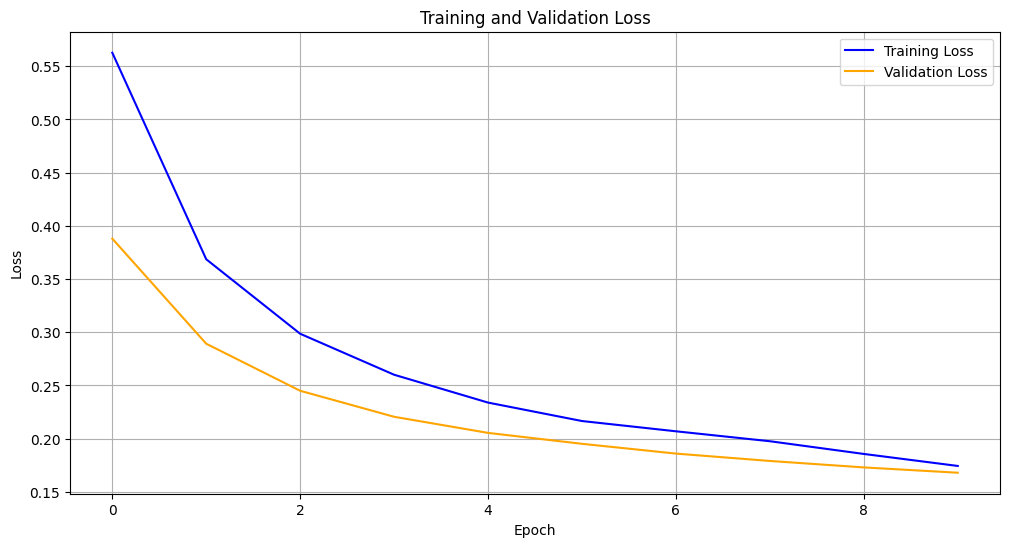

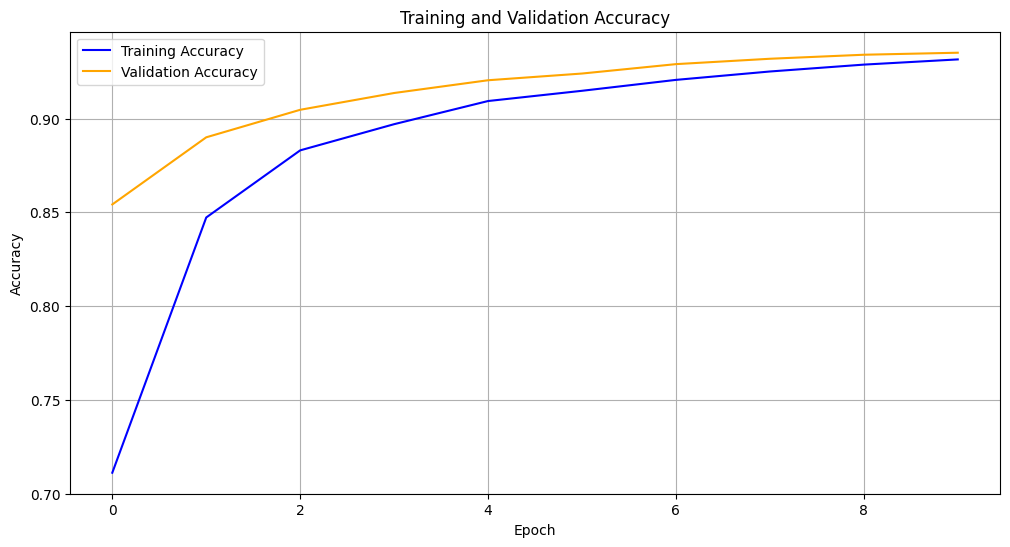

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    # Extract the loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract the accuracy and validation accuracy from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy', color='blue')
    plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot loss curves
plot_loss_curves(history)


# MAKING PREDICTIONS ON THE TEST DATA

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

110/110 [==============================] - 9s 77ms/step
The first 5 predictions: ['millitary', 'other', 'other', 'other', 'millitary']


# RANDOM PICTURES

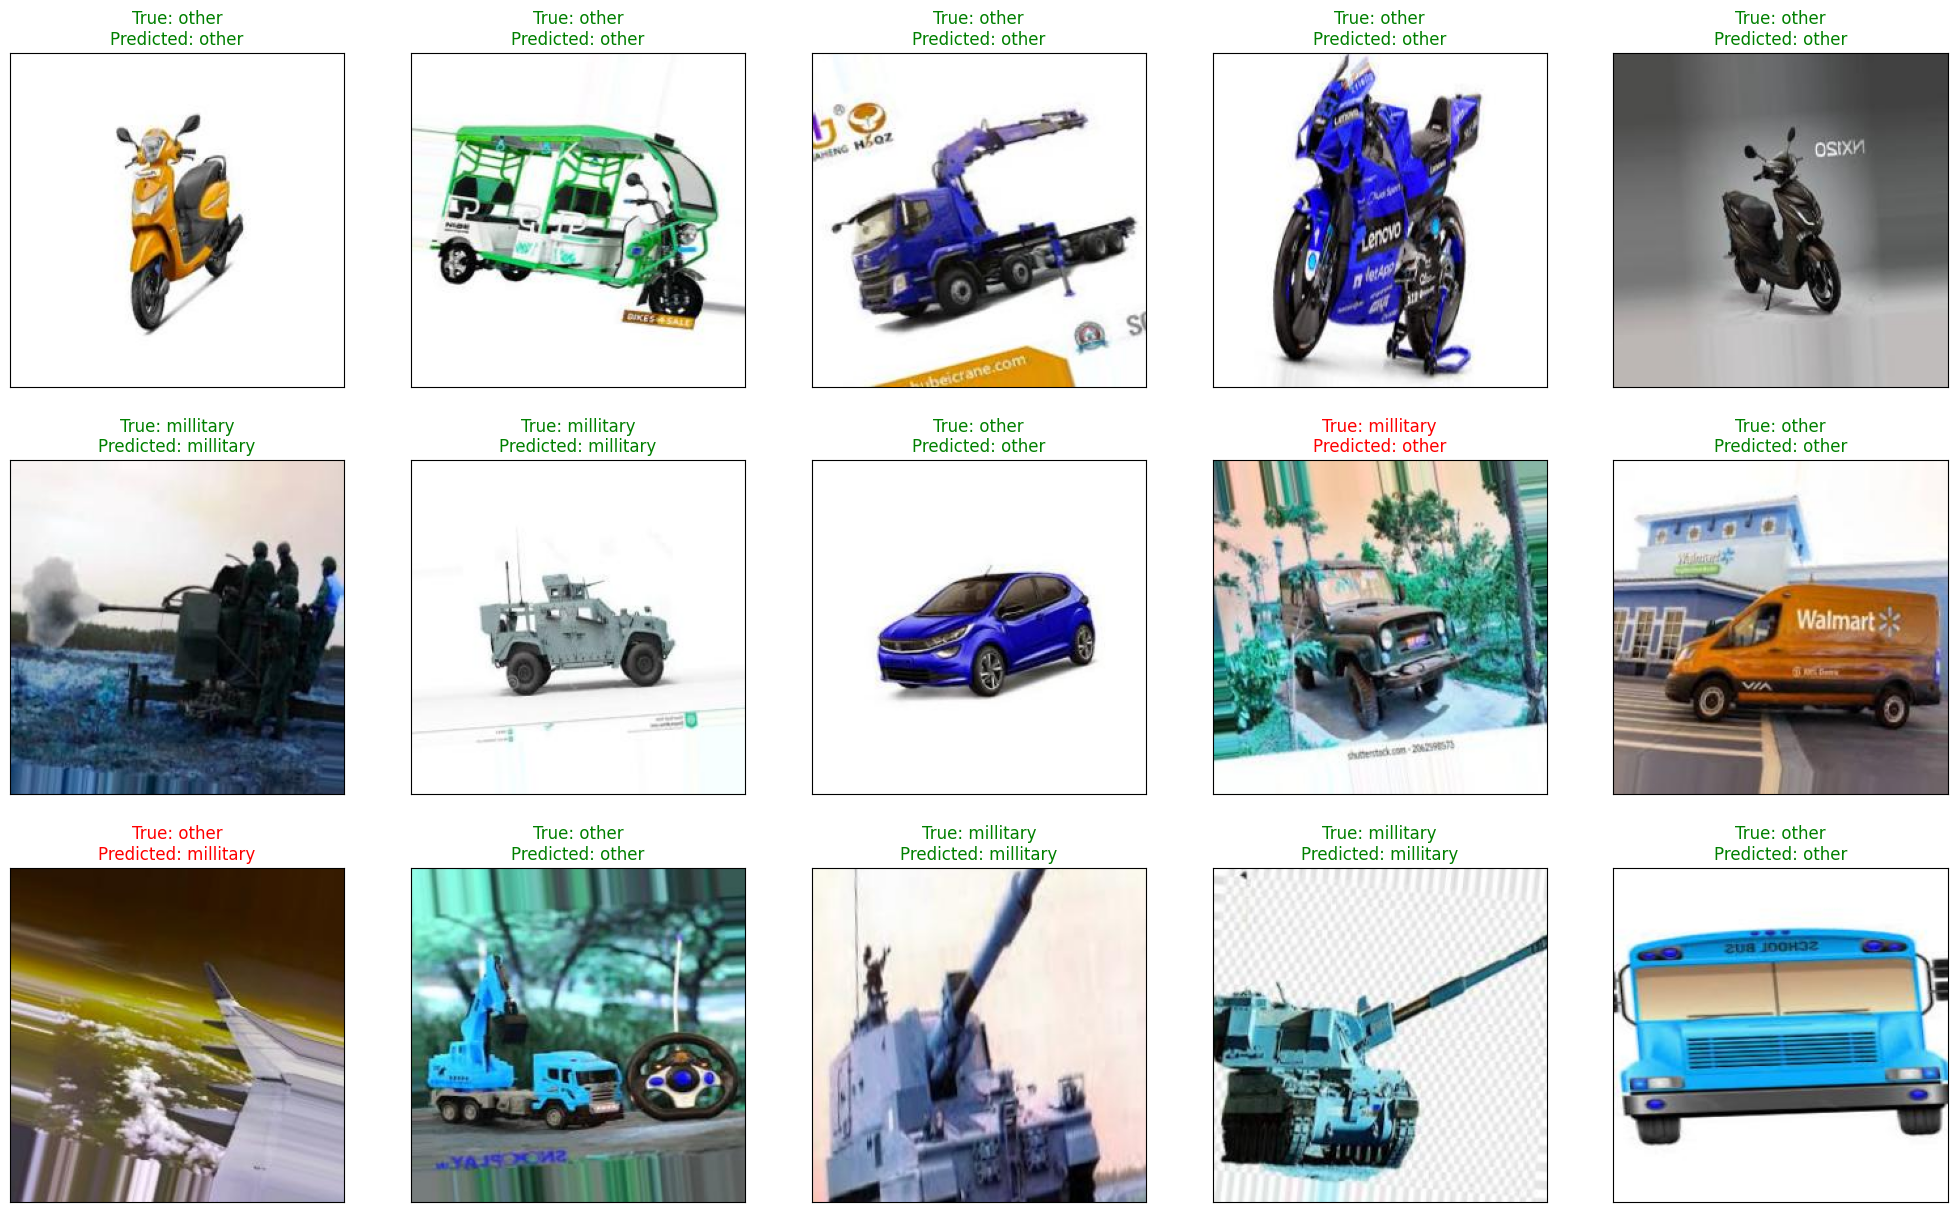

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# CLASSIFICATION REPORTS AND CONFUSION MATRIX

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   millitary       0.94      0.92      0.93      1596
       other       0.94      0.95      0.94      1895

    accuracy                           0.94      3491
   macro avg       0.94      0.94      0.94      3491
weighted avg       0.94      0.94      0.94      3491



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
millitary,0.938854,0.923559,0.931143,1596.000000
other,0.936491,0.949340,0.942872,1895.000000
accuracy,0.937554,0.937554,0.937554,0.937554
macro avg,0.937672,0.936450,0.937008,3491.000000
weighted avg,0.937571,0.937554,0.937510,3491.000000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] if norm else None
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm_norm if norm else cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set the tick labels
    labels = classes if classes is not None else np.arange(n_classes)
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Rotate xticks for readability & increase font size
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(n_classes), range(n_classes)):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure
    if savefig:
        fig.savefig("confusion_matrix.png")

    plt.show()  # Display the plot


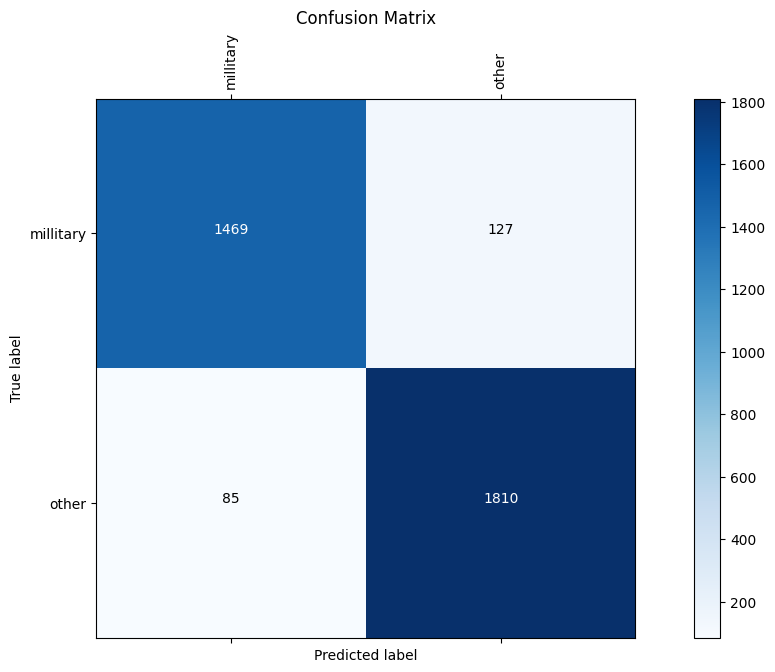

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))